# Task 1 - Face Mask Detection 

In [1]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [3]:
!unzip "/content/drive/MyDrive/dataset-face-mask..zip"

Archive:  /content/drive/MyDrive/dataset-face-mask..zip
  inflating: dataset/with_mask/augmented_image_97.jpg  
  inflating: dataset/with_mask/pra1.jpg  
  inflating: dataset/with_mask/prajna.jpg  
  inflating: dataset/with_mask/pra3.jpg  
  inflating: dataset/with_mask/pra2.jpg  
  inflating: dataset/with_mask/augmented_image_76.jpg  
  inflating: dataset/with_mask/augmented_image_86.jpg  
  inflating: dataset/with_mask/augmented_image_81.jpg  
  inflating: dataset/with_mask/augmented_image_88.jpg  
  inflating: dataset/with_mask/augmented_image_85.jpg  
  inflating: dataset/with_mask/augmented_image_87.jpg  
  inflating: dataset/with_mask/augmented_image_69.jpg  
  inflating: dataset/with_mask/augmented_image_72.jpg  
  inflating: dataset/with_mask/augmented_image_84.jpg  
  inflating: dataset/with_mask/augmented_image_77.jpg  
  inflating: dataset/with_mask/augmented_image_99.jpg  
  inflating: dataset/with_mask/augmented_image_78.jpg  
  inflating: dataset/with_mask/augmented_image

In [4]:
import os
from PIL import Image

DATA_DIR = "/content/dataset"
classes = ["with_mask", "without_mask"]

In [5]:
def get_image_paths(path_dir, class_id):
  image_path_label = []
  for image_name in os.listdir(os.path.join(path_dir, class_id)):
    img_path = os.path.join(path_dir, class_id, image_name)
    image_path_label.append([img_path, class_id])
  return image_path_label

In [6]:
train_test_img_path = get_image_paths(DATA_DIR, classes[0])
train_test_img_path.extend(get_image_paths(DATA_DIR, classes[1]))

In [7]:
len(train_test_img_path)

1376

In [8]:
import pandas as pd

df = pd.DataFrame(train_test_img_path, columns=['image_path', 'label'])
df.head()

image_path      label
0        /content/dataset/with_mask/32-with-mask.jpg  with_mask
1  /content/dataset/with_mask/augmented_image_56.jpg  with_mask
2       /content/dataset/with_mask/114-with-mask.jpg  with_mask
3  /content/dataset/with_mask/augmented_image_28.jpg  with_mask
4  /content/dataset/with_mask/augmented_image_206...  with_mask

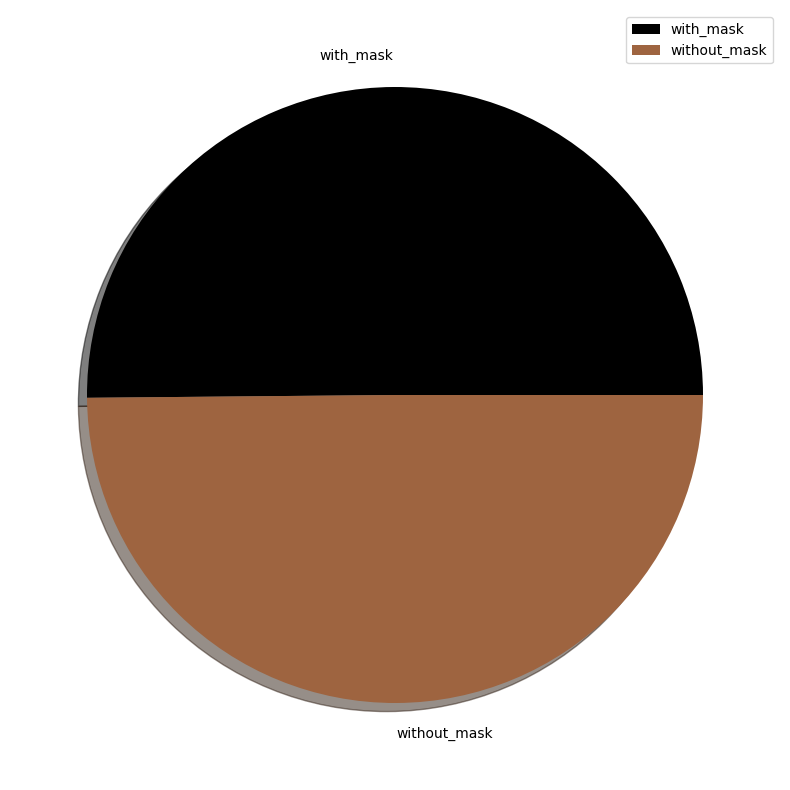

<Figure size 1000x1000 with 0 Axes>

In [9]:
import matplotlib.pyplot as plt

fig1, ax1 = plt.subplots(figsize=(10, 10))
theme = plt.get_cmap('copper')
ax1.set_prop_cycle("color", [theme(1. * i / 2) for i in range(5)])
plt.figure(figsize=(10,10))
ax1.pie(df.label.value_counts(), labels=classes, shadow=True)
ax1.legend()
plt.show()

In [10]:
def visualize_imgs(df, sample_cnt):
    df = df.groupby('label',group_keys = False).apply(lambda df: df.sample(sample_cnt))
    df = df.reset_index(drop = True)
    
    for pt in range(sample_cnt):
        f, axarr = plt.subplots(1,2,figsize = (15,15))
        axarr[0].set_ylabel("Masks/No Masks")  
        temp = df[df.index.isin([pt + (sample_cnt*0),pt + (sample_cnt*1)])]
        for i in range(2):
          axarr[i].set_axis_off()
          axarr[i].imshow(Image.open(temp.image_path.iloc[i]).resize((150,150)))
          axarr[i].set_xlabel('Class '+str(temp.label.iloc[i]))
    plt.show()

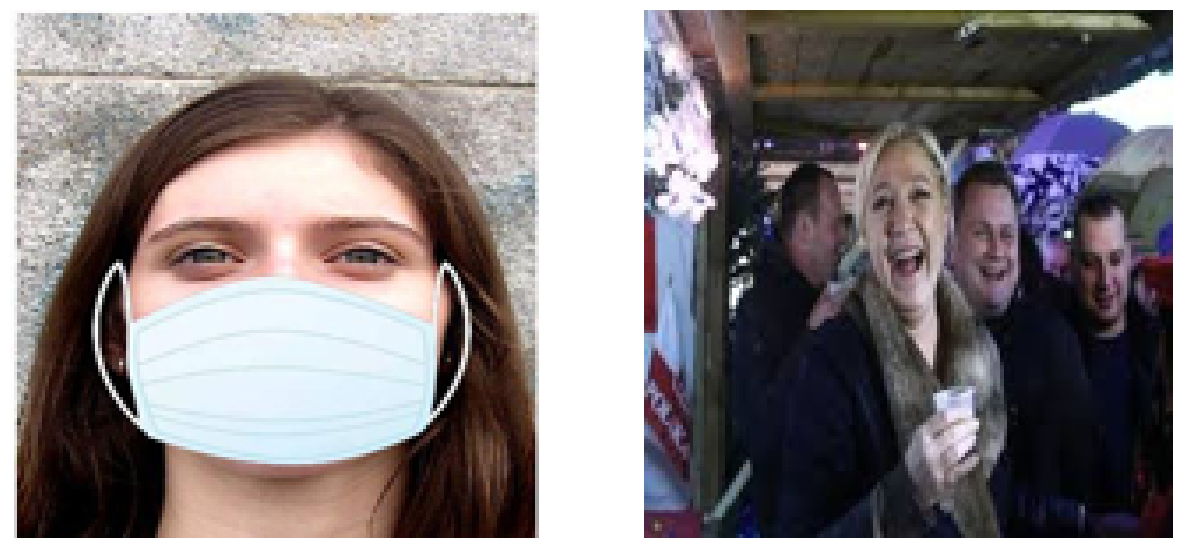

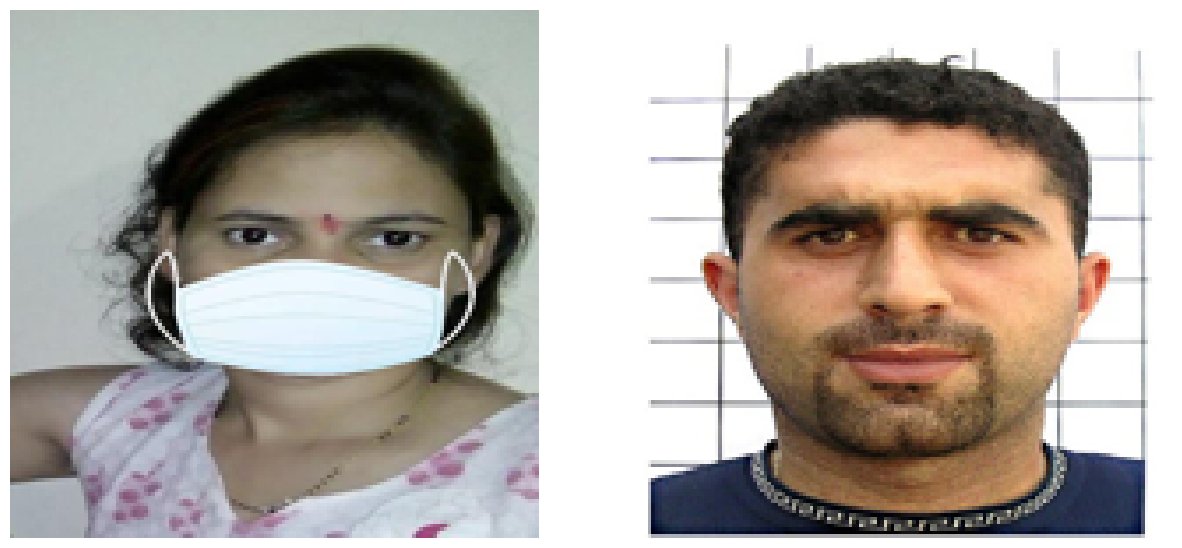

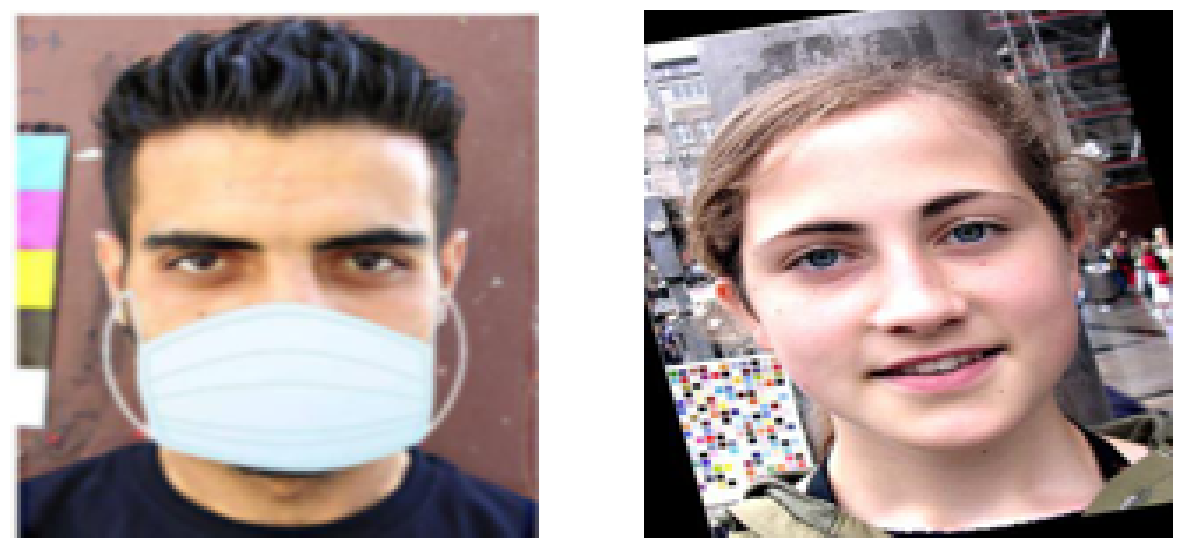

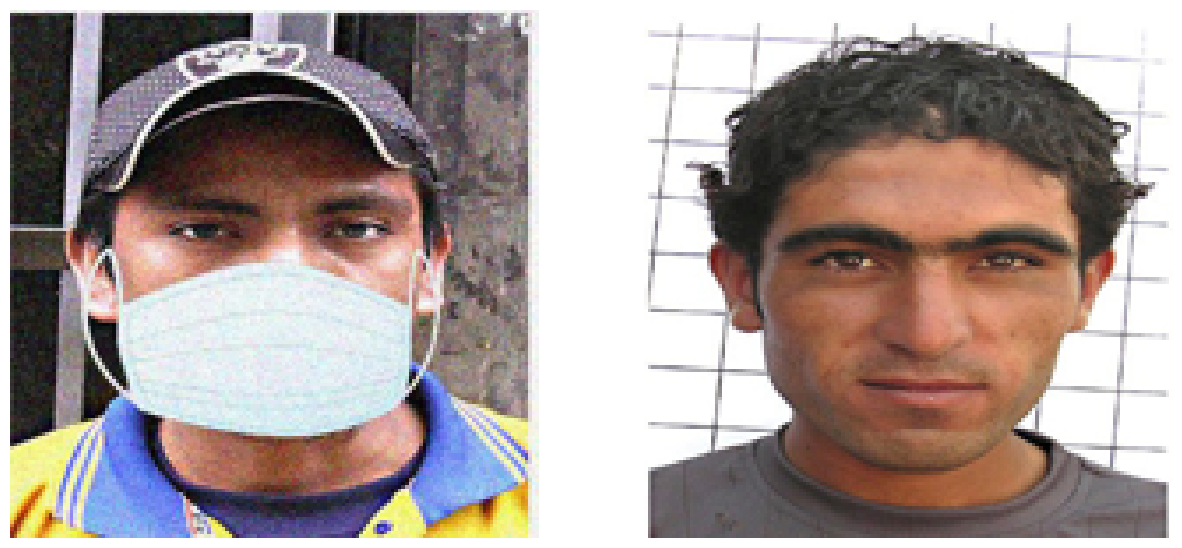

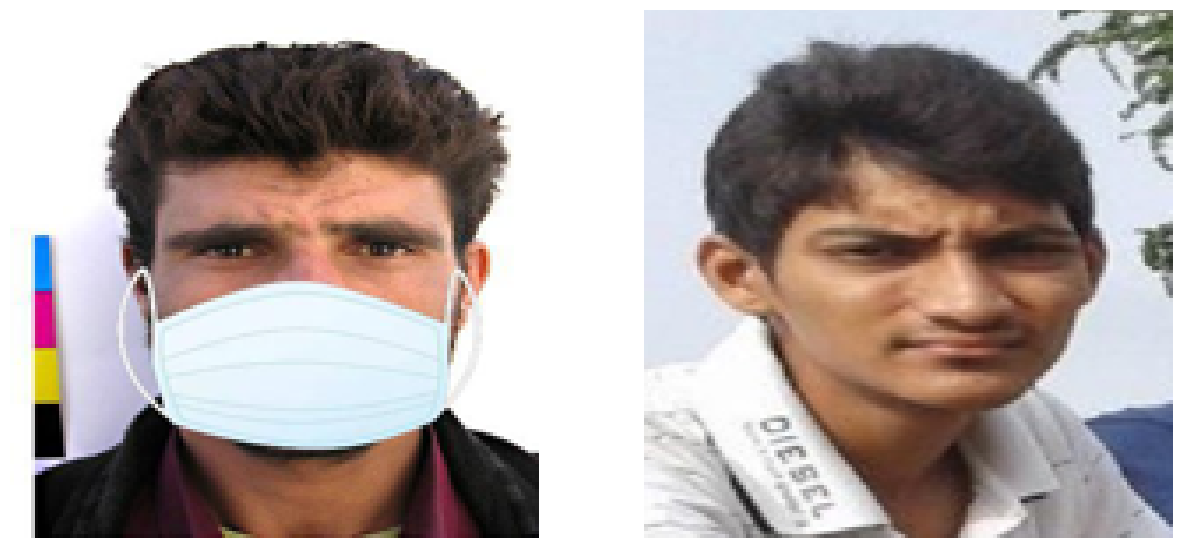

In [11]:
visualize_imgs(df, 5)

In [12]:
df = df.sample(frac = 1)
df.head()

image_path         label
1290  /content/dataset/without_mask/augmented_image_...  without_mask
934   /content/dataset/without_mask/augmented_image_...  without_mask
639    /content/dataset/with_mask/augmented_image_4.jpg     with_mask
1086              /content/dataset/without_mask/354.jpg  without_mask
655   /content/dataset/with_mask/augmented_image_166...     with_mask

In [13]:
from sklearn.model_selection import train_test_split

train, test = train_test_split(df, test_size=0.05, random_state=42, shuffle=True)

In [14]:
print("Training Data", train.shape)
print("Test Data", test.shape)

Training Data (1307, 2)
Test Data (69, 2)


In [37]:
!pip install --upgrade keras

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [40]:
from keras.preprocessing.image import ImageDataGenerator
from keras.layers.convolutional import Conv2D
from keras.layers.convolutional import MaxPooling2D
from keras.layers.pooling import GlobalAveragePooling2D
from keras.layers import Input
from keras.models import Model
from keras.layers.core import Dropout
from keras.layers.core import Flatten
from keras.layers.core import Dense
from keras.callbacks import ModelCheckpoint
from keras.callbacks import ReduceLROnPlateau
from keras.callbacks import EarlyStopping

from keras.activations import softmax
from keras.activations import elu
from keras.activations import relu
from keras.optimizers import Adam
from keras.optimizers import RMSprop
from keras.optimizers import SGD, Adam
from keras.layers import BatchNormalization
import tensorflow as tf
from tensorflow.keras.preprocessing import image

In [19]:
BATCH_SIZE = 4
EPOCHS = 30
WARMUP_EPOCHS = 2
LEARNING_RATE = 1e-4
WARMUP_LEARNING_RATE = 1e-3
HEIGHT = 320
WIDTH = 320
CANAL = 3
N_CLASSES = train['label'].nunique()
ES_PATIENCE = 2
RLROP_PATIENCE = 3
DECAY_DROP = 0.5
IMG_DIM = 320

### Data Loaders & Preprocessing

In [20]:
train_datagen = ImageDataGenerator(rescale=1./255, 
                                    validation_split=0.1, 
                                    horizontal_flip=True)

In [21]:
train_generator = train_datagen.flow_from_dataframe(dataframe=train,
                                                    directory=DATA_DIR,
                                                    x_col="image_path",
                                                    y_col="label",
                                                    batch_size=BATCH_SIZE,
                                                    class_mode="categorical",
                                                    target_size=(IMG_DIM, IMG_DIM),
                                                    subset='training',
                                                    shuffle=True
                                                    )

Found 1177 validated image filenames belonging to 2 classes.


In [22]:
valid_generator = train_datagen.flow_from_dataframe(dataframe=train,
                                                    directory=DATA_DIR,
                                                    x_col="image_path",
                                                    y_col="label",
                                                    batch_size=BATCH_SIZE,
                                                    class_mode="categorical",
                                                    target_size=(IMG_DIM, IMG_DIM),
                                                    subset='validation',
                                                    shuffle=True
                                                    )

Found 130 validated image filenames belonging to 2 classes.


### Transfer Learning

In [23]:
base_model = tf.keras.applications.Xception(include_top=False,
                                       input_shape=(None, None, 3),
                                       weights='imagenet')
base_model.trainable = False
layer = tf.keras.layers.GlobalAveragePooling2D()(base_model.output)
layer = tf.keras.layers.Dense(1024, activation='relu')(layer)
layer = tf.keras.layers.Dropout(0.5)(layer)
output = tf.keras.layers.Dense(N_CLASSES, activation='softmax')(layer)
model = tf.keras.models.Model(base_model.inputs,output)

83683744/83683744 [==============================] - 4s 0us/step


In [24]:
STEP_SIZE_TRAIN = train_generator.n//train_generator.batch_size
STEP_SIZE_VALID = valid_generator.n//valid_generator.batch_size
print(STEP_SIZE_TRAIN,STEP_SIZE_VALID)

294 32


In [25]:
for layer in model.layers:
    layer.trainable = True

es = EarlyStopping(monitor='val_loss', mode='min', patience=ES_PATIENCE, restore_best_weights=True, verbose=1)
rlrop = ReduceLROnPlateau(monitor='val_loss', mode='min', patience=RLROP_PATIENCE, factor=DECAY_DROP, min_lr=1e-6, verbose=1)

callback_list = [es, rlrop]
optimizer = Adam(lr=LEARNING_RATE)
model.compile(optimizer=optimizer, loss="binary_crossentropy",  metrics=['accuracy'])
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, None, None,  0           []                               
                                 3)]                                                              
                                                                                                  
 block1_conv1 (Conv2D)          (None, None, None,   864         ['input_1[0][0]']                
                                32)                                                               
                                                                                                  
 block1_conv1_bn (BatchNormaliz  (None, None, None,   128        ['block1_conv1[0][0]']           
 ation)                         32)                                                           

/usr/local/lib/python3.10/dist-packages/keras/optimizers/legacy/adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


 block6_sepconv2_bn (BatchNorma  (None, None, None,   2912       ['block6_sepconv2[0][0]']        
 lization)                      728)                                                              
                                                                                                  
 block6_sepconv3_act (Activatio  (None, None, None,   0          ['block6_sepconv2_bn[0][0]']     
 n)                             728)                                                              
                                                                                                  
 block6_sepconv3 (SeparableConv  (None, None, None,   536536     ['block6_sepconv3_act[0][0]']    
 2D)                            728)                                                              
                                                                                                  
 block6_sepconv3_bn (BatchNorma  (None, None, None,   2912       ['block6_sepconv3[0][0]']        
 lization)

In [26]:
history_finetunning = model.fit_generator(generator=train_generator,
                                          steps_per_epoch=STEP_SIZE_TRAIN,
                                          validation_data=valid_generator,
                                          validation_steps=STEP_SIZE_VALID,
                                          epochs=EPOCHS,
                                          callbacks=callback_list,
                                          verbose=1).history

Epoch 1/30


<ipython-input-26-0b2fa1e499fd>:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history_finetunning = model.fit_generator(generator=train_generator,


294/294 [==============================] - 55s 135ms/step - loss: 0.1111 - accuracy: 0.9608 - val_loss: 0.0177 - val_accuracy: 0.9922 - lr: 1.0000e-04
Epoch 2/30
294/294 [==============================] - 39s 132ms/step - loss: 0.0052 - accuracy: 0.9983 - val_loss: 8.1528e-05 - val_accuracy: 1.0000 - lr: 1.0000e-04
Epoch 3/30
294/294 [==============================] - 40s 136ms/step - loss: 8.6156e-04 - accuracy: 1.0000 - val_loss: 2.4702e-05 - val_accuracy: 1.0000 - lr: 1.0000e-04
Epoch 4/30
294/294 [==============================] - 40s 135ms/step - loss: 2.6043e-04 - accuracy: 1.0000 - val_loss: 8.3238e-06 - val_accuracy: 1.0000 - lr: 1.0000e-04
Epoch 5/30
294/294 [==============================] - ETA: 0s - loss: 3.2286e-04 - accuracy: 1.0000
Epoch 5: ReduceLROnPlateau reducing learning rate to 4.999999873689376e-05.
294/294 [==============================] - 39s 134ms/step - loss: 3.2286e-04 - accuracy: 1.0000 - val_loss: 3.1587e-04 - val_accuracy: 1.0000 - lr: 1.0000e-04
Epoch 6/

### Evaluating Model Performance

In [27]:
test_datagen = ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_dataframe(dataframe=test,
                                                  directory = DATA_DIR,
                                                  x_col="image_path",
                                                  target_size=(HEIGHT, WIDTH),
                                                  batch_size=1,
                                                  shuffle=False,
                                                  class_mode=None)

Found 69 validated image filenames.


In [28]:
import numpy as np

test_generator.reset()
STEP_SIZE_TEST = test_generator.n//test_generator.batch_size
test_preds = model.predict_generator(test_generator, steps=STEP_SIZE_TEST,verbose = 1)
test_labels = [np.argmax(pred) for pred in test_preds]

<ipython-input-28-c5fb4796a972>:5: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  test_preds = model.predict_generator(test_generator, steps=STEP_SIZE_TEST,verbose = 1)


69/69 [==============================] - 2s 16ms/step


In [29]:
true_labels = [0 if x == 'with_mask' else 1 for x in test.label.tolist()]

In [30]:
from sklearn.metrics import accuracy_score, recall_score, precision_score, classification_report

print("Accuracy for test: ", round(accuracy_score(true_labels, test_labels), 3))
print("Recall for test: ", round(recall_score(true_labels, test_labels), 3))
print("Precision for test: ", round(precision_score(true_labels, test_labels), 3))
print("------------------------------")
print("Classification Report")
print(classification_report(true_labels, test_labels))

Accuracy for test:  1.0
Recall for test:  1.0
Precision for test:  1.0
------------------------------
Classification Report
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        34
           1       1.00      1.00      1.00        35

    accuracy                           1.00        69
   macro avg       1.00      1.00      1.00        69
weighted avg       1.00      1.00      1.00        69



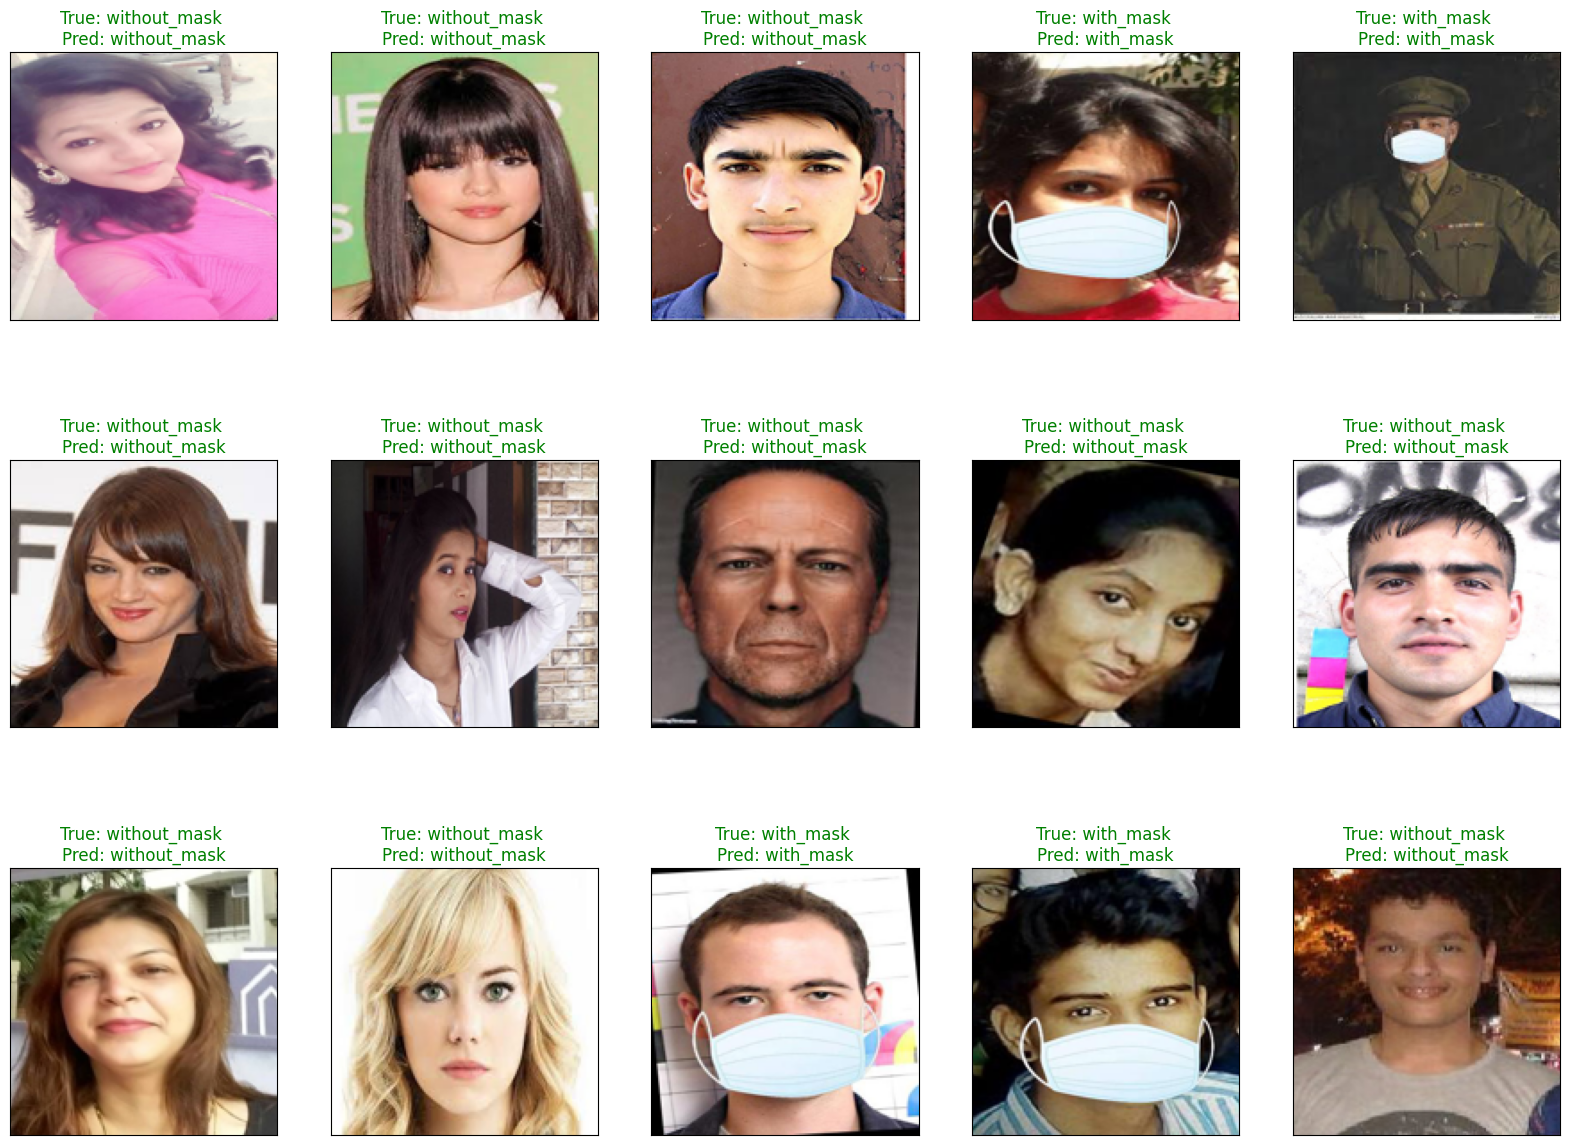

In [31]:
figure = plt.figure(figsize=(20, 15))
for i, index in enumerate(np.random.choice(test.shape[0], size=15, replace=False)):
    ax = figure.add_subplot(3, 5, i + 1, xticks=[], yticks=[])
    # Display each image
    img = Image.open(test.iloc[index, 0]).resize((150,150))
    ax.imshow(img)
    predict_index = true_labels[index]
    true_index = test_labels[index]
    # Set the title for each image
    title_color = ("green" if predict_index == true_index else "red")
    ax.set_title("True: {} \nPred: {}".format(classes[predict_index], classes[true_index]), color=title_color)
plt.show()

In [32]:
from skimage import io
import warnings
from keras.preprocessing import image

warnings.filterwarnings("ignore")

def predict_image(img_path, model):
  img = image.load_img(img_path, grayscale=False, target_size=(320, 320))
  show_img=image.load_img(img_path, grayscale=False, target_size=(200, 200))
  x = image.img_to_array(img)
  x = np.expand_dims(x, axis = 0)

  x /= 255

  custom = model.predict(x)

  x = np.array(x, 'float32')

  plt.gray()
  plt.imshow(show_img)
  plt.xticks([])
  plt.yticks([])

  plt.show()

  objects = ["with_mask", "without_mask"]

  m=-9999
  a=custom[0]
  sorted_a = sorted(a, reverse=True)
  sorted_indx = np.argsort(a)
  sorted_indx = sorted_indx[::-1]

  sorted_labels = [objects[x] for x in sorted_indx]

  for conf, label in zip(sorted_a, sorted_labels):
    print(label, ":", conf*100)

In [33]:
from google.colab import files
fn = files.upload()

Saving augmented_image_191.jpg to augmented_image_191.jpg


1/1 [==============================] - 0s 29ms/step


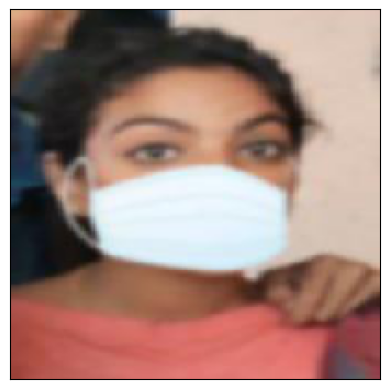

with_mask : 100.0
without_mask : 4.678849755551662e-10


In [41]:
for f in fn.keys():
  file_name = f
  predict_image(file_name, model)

In [51]:
import cv2
import numpy as np

trained_face_data = cv2.CascadeClassifier("/content/haarcascade_frontalface_default.xml")

def detect_faces(image):
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    height = image.shape[0]
    width = image.shape[1]
    face_coordinates = trained_face_data.detectMultiScale(image)
    for coordinate in face_coordinates:
        (x, y, w, h) = coordinate
        colors = np.random.randint(1, 255, 3)
        roi = image[y:y+w,x:x+h]
        img_pixels = cv2.resize(roi, (320, 320))
        img_pixels = img_pixels.astype(np.float32)
        img_pixels /= 255
        img_pixels = np.expand_dims(img_pixels, axis = 0)

        predictions = model.predict(img_pixels)
        max_index = np.argmax(predictions[0])
        classes = ('with_mask', 'without_mask')
        predicted_classes = classes[max_index]

        cv2.putText(image, predicted_classes, (int(x), int(y)), cv2.FONT_HERSHEY_SIMPLEX, 1, (0,0,255), 2)
        cv2.rectangle(image, (x, y), (x + w, y + h), (int(colors[0]), int(colors[1]), int(colors[2])), thickness=2)
    image = cv2.resize(image, (width, height))
    plt.xticks([])
    plt.yticks([])
    plt.imshow(image)
    plt.show()

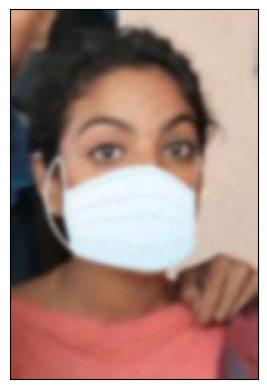

In [54]:
img = cv2.imread("/content/augmented_image_191.jpg")
detect_faces(img)

In [55]:
from google.colab import files
fn = files.upload()

Saving augmented_image_92.jpg to augmented_image_92.jpg


1/1 [==============================] - 0s 22ms/step


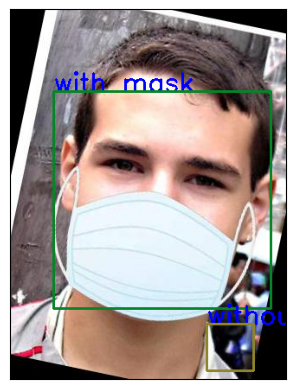

In [56]:
%matplotlib inline

for f in fn.keys():
  file_name = f
  img = cv2.imread(file_name)
  detect_faces(img)

In [57]:
model.save("mask_pred.h5")

### Simple CNN

In [58]:
model_2 = tf.keras.Sequential()

model_2.add(tf.keras.layers.Conv2D(filters=64, kernel_size=2, padding='same', activation='relu', input_shape=(320, 320, 3))) 
model_2.add(tf.keras.layers.MaxPooling2D(pool_size=2))
model_2.add(tf.keras.layers.Dropout(0.3))

model_2.add(tf.keras.layers.Conv2D(filters=32, kernel_size=2, padding='same', activation='relu'))
model_2.add(tf.keras.layers.MaxPooling2D(pool_size=2))
model_2.add(tf.keras.layers.Dropout(0.3))

model_2.add(tf.keras.layers.Flatten())

model_2.add(tf.keras.layers.Dense(256, activation='relu'))
model_2.add(tf.keras.layers.Dropout(0.5))
model_2.add(tf.keras.layers.Dense(2, activation='sigmoid'))

model_2.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 320, 320, 64)      832       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 160, 160, 64)     0         
 )                                                               
                                                                 
 dropout_1 (Dropout)         (None, 160, 160, 64)      0         
                                                                 
 conv2d_5 (Conv2D)           (None, 160, 160, 32)      8224      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 80, 80, 32)       0         
 2D)                                                             
                                                                 
 dropout_2 (Dropout)         (None, 80, 80, 32)        0

In [59]:
es = EarlyStopping(monitor='val_loss', mode='min', patience=ES_PATIENCE, restore_best_weights=True, verbose=1)

callback_list = [es]
optimizer = Adam(lr=LEARNING_RATE)
model_2.compile(optimizer=optimizer, loss="binary_crossentropy",  metrics=['accuracy'])
model_2.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 320, 320, 64)      832       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 160, 160, 64)     0         
 )                                                               
                                                                 
 dropout_1 (Dropout)         (None, 160, 160, 64)      0         
                                                                 
 conv2d_5 (Conv2D)           (None, 160, 160, 32)      8224      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 80, 80, 32)       0         
 2D)                                                             
                                                                 
 dropout_2 (Dropout)         (None, 80, 80, 32)        0

In [60]:
history = model_2.fit_generator(generator=train_generator,
                              steps_per_epoch=STEP_SIZE_TRAIN,
                              validation_data=valid_generator,
                              validation_steps=STEP_SIZE_VALID,
                              epochs=EPOCHS,
                              verbose=1,
                              callbacks=callback_list).history

Epoch 1/30
294/294 [==============================] - 18s 57ms/step - loss: 0.5318 - accuracy: 0.7809 - val_loss: 0.3931 - val_accuracy: 0.9531
Epoch 2/30
294/294 [==============================] - 16s 53ms/step - loss: 0.1848 - accuracy: 0.9335 - val_loss: 0.2688 - val_accuracy: 0.9453
Epoch 3/30
294/294 [==============================] - 16s 53ms/step - loss: 0.1329 - accuracy: 0.9523 - val_loss: 0.1942 - val_accuracy: 0.9688
Epoch 4/30
294/294 [==============================] - 16s 54ms/step - loss: 0.1023 - accuracy: 0.9736 - val_loss: 0.1794 - val_accuracy: 0.9609
Epoch 5/30
294/294 [==============================] - 16s 53ms/step - loss: 0.0976 - accuracy: 0.9668 - val_loss: 0.1423 - val_accuracy: 0.9766
Epoch 6/30
294/294 [==============================] - 16s 54ms/step - loss: 0.0676 - accuracy: 0.9804 - val_loss: 0.1175 - val_accuracy: 0.9609
Epoch 7/30
294/294 [==============================] - 16s 53ms/step - loss: 0.0731 - accuracy: 0.9753 - val_loss: 0.1095 - val_accuracy:

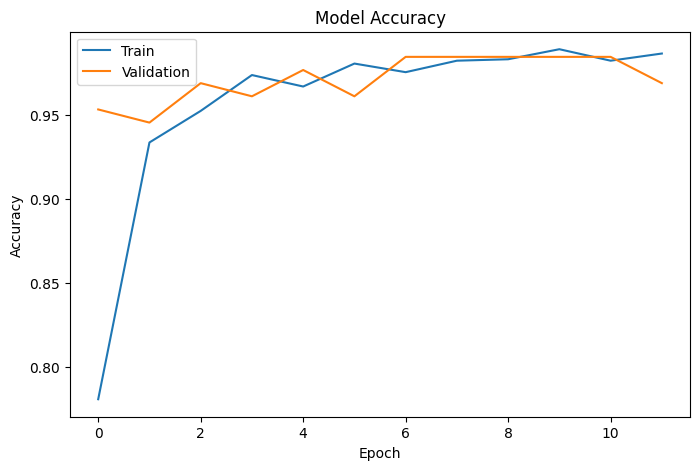

In [61]:
plt.figure(figsize=(8,5))

plt.plot(history['accuracy'])
plt.plot(history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.gca().ticklabel_format(axis='both', style='plain', useOffset=False)
plt.show()

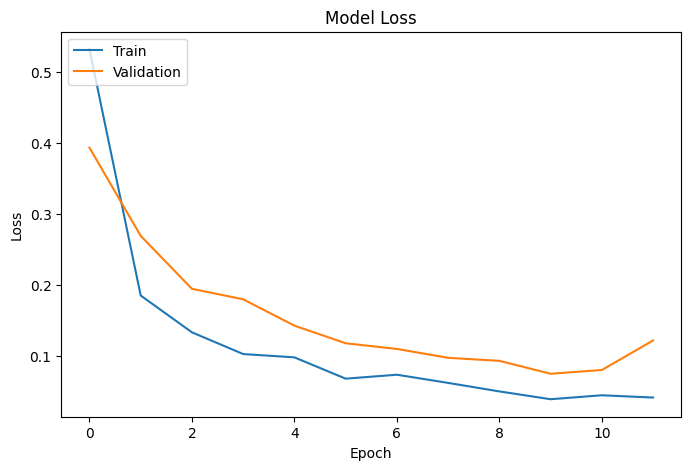

In [62]:
plt.figure(figsize=(8,5))

plt.plot(history['loss'])
plt.plot(history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.gca().ticklabel_format(axis='both', style='plain', useOffset=False)
plt.show()

In [63]:
import numpy as np

test_generator.reset()
STEP_SIZE_TEST = test_generator.n//test_generator.batch_size
test_preds = model_2.predict_generator(test_generator, steps=STEP_SIZE_TEST,verbose = 1)
test_labels = [np.argmax(pred) for pred in test_preds]
true_labels = [0 if x == 'with_mask' else 1 for x in test.label.tolist()]

69/69 [==============================] - 1s 8ms/step


In [64]:
from sklearn.metrics import accuracy_score, recall_score, precision_score, classification_report

print("Accuracy for test: ", round(accuracy_score(true_labels, test_labels), 3))
print("Recall for test: ", round(recall_score(true_labels, test_labels), 3))
print("Precision for test: ", round(precision_score(true_labels, test_labels), 3))
print("------------------------------")
print("Classification Report")
print(classification_report(true_labels, test_labels))

Accuracy for test:  0.986
Recall for test:  1.0
Precision for test:  0.972
------------------------------
Classification Report
              precision    recall  f1-score   support

           0       1.00      0.97      0.99        34
           1       0.97      1.00      0.99        35

    accuracy                           0.99        69
   macro avg       0.99      0.99      0.99        69
weighted avg       0.99      0.99      0.99        69



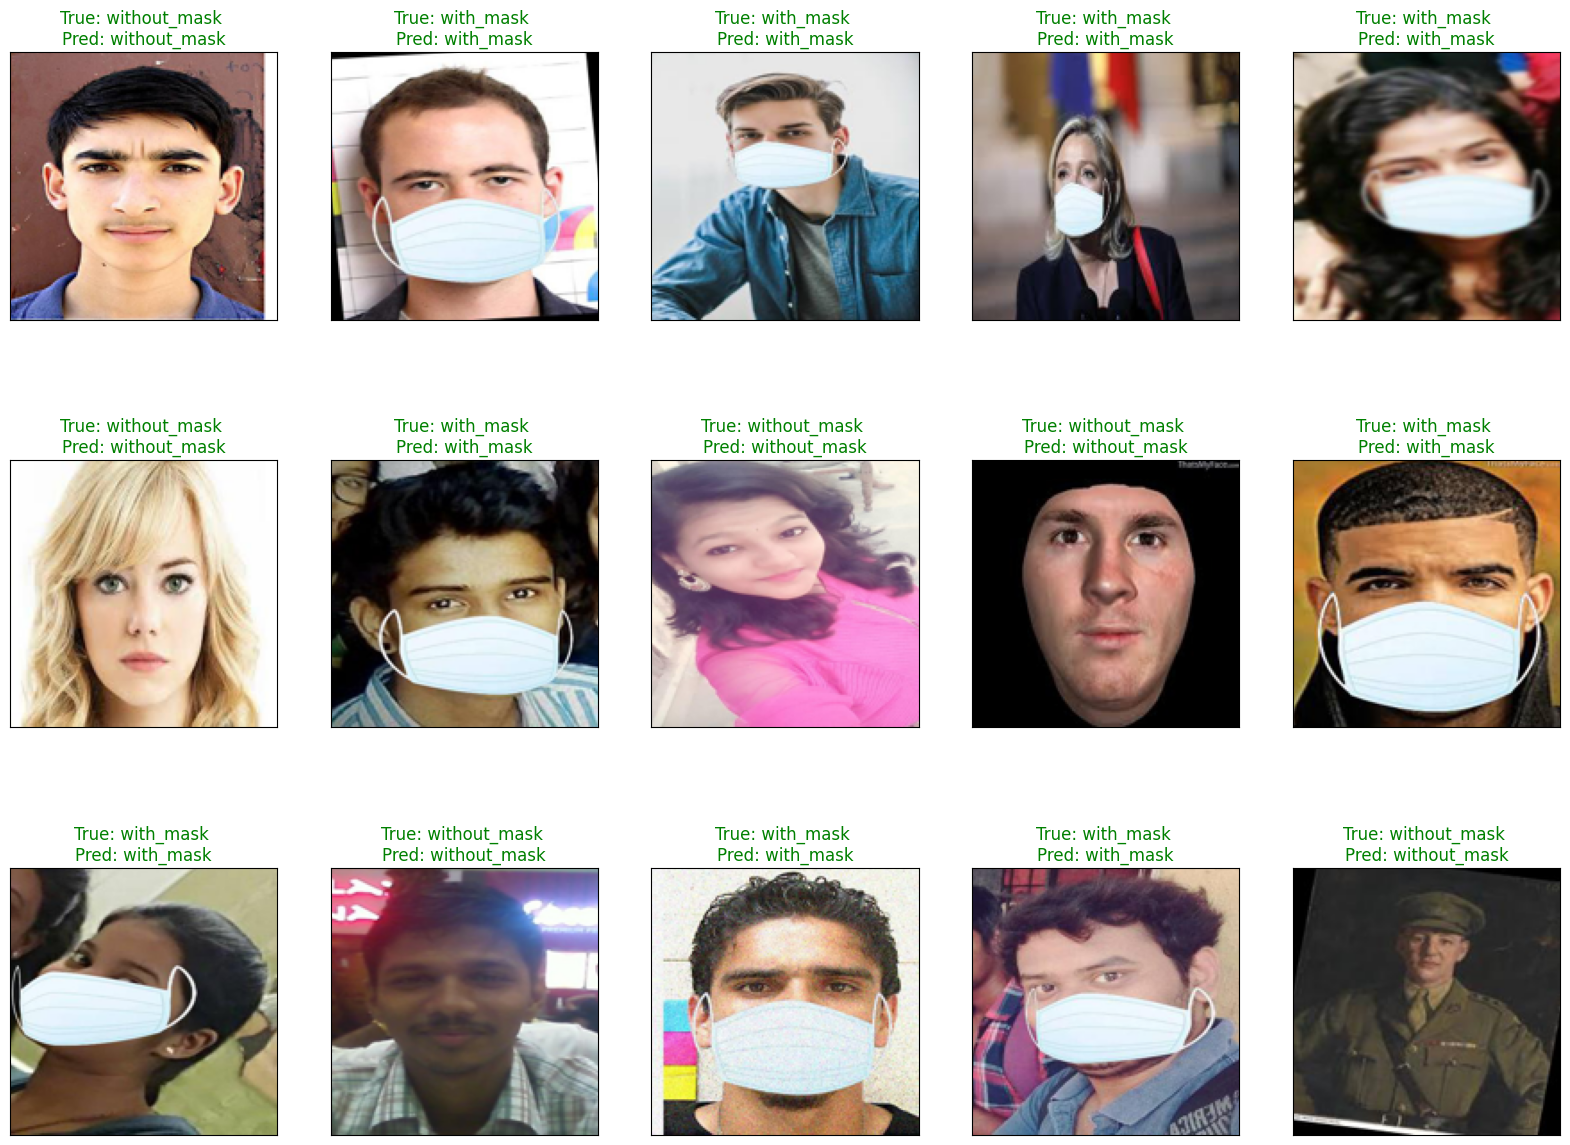

In [65]:
figure = plt.figure(figsize=(20, 15))
for i, index in enumerate(np.random.choice(test.shape[0], size=15, replace=False)):
    ax = figure.add_subplot(3, 5, i + 1, xticks=[], yticks=[])
    # Display each image
    img = Image.open(test.iloc[index, 0]).resize((150,150))
    ax.imshow(img)
    predict_index = true_labels[index]
    true_index = test_labels[index]
    # Set the title for each image
    title_color = ("green" if predict_index == true_index else "red")
    ax.set_title("True: {} \nPred: {}".format(classes[predict_index], classes[true_index]), color=title_color)
plt.show()

## Real-time Prediction Verifier

Using the model that we trained, we will open the web cam live with the help of OpenCV and predict the mask/no_mask in real-time.

*** The code below has been tested successfully on my local machine.

In [ ]:
import cv2
import numpy as np
import tensorflow as tf


model_load = tf.keras.models.load_model("mask_pred.h5")

face_cascade = cv2.CascadeClassifier('haarcascade_frontalface_default.xml')
cap=cv2.VideoCapture(0)

while True:
    ret,test_img=cap.read()# captures frame and returns boolean value and captured image
    if not ret:
      continue
    gray_img= cv2.cvtColor(test_img, cv2.COLOR_BGR2GRAY)
    faces_detected = face_cascade.detectMultiScale(gray_img, 1.32, 5)
    for (x,y,w,h) in faces_detected:
        cv2.rectangle(test_img,(x,y),(x+w,y+h),(255,0,0),thickness=2)
        roi_gray=gray_img[y:y+w,x:x+h]#cropping region of interest i.e. face area from  image
        img_pixels = cv2.cvtColor(roi_gray, cv2.COLOR_GRAY2RGB)
        img_pixels = cv2.resize(img_pixels, (256, 256))
        img_pixels = img_pixels.astype(np.float32)
        img_pixels /= 255
        img_pixels = np.expand_dims(img_pixels, axis = 0)

        predictions = model_load.predict(img_pixels)

        #find max indexed array
        max_index = np.argmax(predictions[0])

        mask = ('male', 'female')
        predicted_mask = mask[max_index]

        cv2.putText(test_img, predicted_mask, (int(x), int(y)), cv2.FONT_HERSHEY_SIMPLEX, 1, (0,0,255), 1)

    resized_img = cv2.resize(test_img, (1000, 700))
    cv2.imshow('mask Prediction ', resized_img)

    if cv2.waitKey(10) == ord('q'):#wait until 'q' key is pressed
        break

cap.release()
cv2.destroyAllWindows

# Task 2 - Mask RCNN

In [67]:
!git clone https://github.com/facebookresearch/Detectron.git

Cloning into 'Detectron'...
remote: Enumerating objects: 1387, done.
remote: Counting objects: 100% (17/17), done.
remote: Compressing objects: 100% (13/13), done.
remote: Total 1387 (delta 5), reused 14 (delta 4), pack-reused 1370
Receiving objects: 100% (1387/1387), 4.39 MiB | 15.77 MiB/s, done.
Resolving deltas: 100% (829/829), done.


In [68]:
cd "/content/Detectron"

/content/Detectron


In [69]:
!pip install -r requirements.txt

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 375.8/375.8 kB 31.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pyyaml: filename=PyYAML-3.12-cp310-cp310-linux_x86_64.whl size=43072 sha256=10f790d265137794b3e8371b3d755288c235f5b3f0210954760d277e75c2c696
  Stored in directory: /root/.cache/pip/wheels/07/6e/47/016d2f3eb7e630a7ad552d6bdfbd570696d74267a47e88d48a
Successfully built pyyaml
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 6.0
    Uninstalling PyYAML-6.0:
      Successfully uninstalled PyYAML-6.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
astropy 5.2.2 requires PyYAML>=3.13, but you have pyyaml 3.12 which is incompatible.
dask 2022.12.1 requires pyyaml>=5.3.1, but you have pyyaml 3.12 which is incomp

In [70]:
!python setup.py install

Compiling detectron/utils/cython_bbox.pyx because it changed.
Compiling detectron/utils/cython_nms.pyx because it changed.
[1/2] Cythonizing detectron/utils/cython_bbox.pyx
/usr/local/lib/python3.10/dist-packages/Cython/Compiler/Main.py:369: FutureWarning: Cython directive 'language_level' not set, using 2 for now (Py2). This will change in a later release! File: /content/Detectron/detectron/utils/cython_bbox.pyx
  tree = Parsing.p_module(s, pxd, full_module_name)
[2/2] Cythonizing detectron/utils/cython_nms.pyx
/usr/local/lib/python3.10/dist-packages/Cython/Compiler/Main.py:369: FutureWarning: Cython directive 'language_level' not set, using 2 for now (Py2). This will change in a later release! File: /content/Detectron/detectron/utils/cython_nms.pyx
  tree = Parsing.p_module(s, pxd, full_module_name)
running install
/usr/local/lib/python3.10/dist-packages/setuptools/_distutils/cmd.py:66: SetuptoolsDeprecationWarning: setup.py install is deprecated.
!!

        ************************

In [71]:
!wget "https://dl.fbaipublicfiles.com/detectron/36494496/12_2017_baselines/e2e_mask_rcnn_X-101-64x4d-FPN_1x.yaml.07_50_11.fkwVtEvg/output/train/coco_2014_train%3Acoco_2014_valminusminival/generalized_rcnn/model_final.pkl"

--2023-05-28 09:28:20--  https://dl.fbaipublicfiles.com/detectron/36494496/12_2017_baselines/e2e_mask_rcnn_X-101-64x4d-FPN_1x.yaml.07_50_11.fkwVtEvg/output/train/coco_2014_train%3Acoco_2014_valminusminival/generalized_rcnn/model_final.pkl
Resolving dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)... 52.84.251.27, 52.84.251.106, 52.84.251.15, ...
Connecting to dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)|52.84.251.27|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 824223517 (786M) [binary/octet-stream]
Saving to: ‘model_final.pkl’

model_final.pkl     100%[===================>] 786.04M   142MB/s    in 7.8s    

2023-05-28 09:28:27 (100 MB/s) - ‘model_final.pkl’ saved [824223517/824223517]



In [72]:
%%bash
make

python setup.py develop --user
running develop
running egg_info
writing Detectron.egg-info/PKG-INFO
writing dependency_links to Detectron.egg-info/dependency_links.txt
writing top-level names to Detectron.egg-info/top_level.txt
reading manifest file 'Detectron.egg-info/SOURCES.txt'
adding license file 'LICENSE'
adding license file 'NOTICE'
writing manifest file 'Detectron.egg-info/SOURCES.txt'
running build_ext
copying build/lib.linux-x86_64-cpython-310/detectron/utils/cython_bbox.cpython-310-x86_64-linux-gnu.so -> detectron/utils
copying build/lib.linux-x86_64-cpython-310/detectron/utils/cython_nms.cpython-310-x86_64-linux-gnu.so -> detectron/utils
Creating /root/.local/lib/python3.10/site-packages/Detectron.egg-link (link to .)
Adding Detectron 0.0.0 to easy-install.pth file

Installed /content/Detectron
Processing dependencies for Detectron==0.0.0
Finished processing dependencies for Detectron==0.0.0


/usr/local/lib/python3.10/dist-packages/setuptools/command/develop.py:40: EasyInstallDeprecationWarning: easy_install command is deprecated.
!!

        ********************************************************************************
        Please avoid running ``setup.py`` and ``easy_install``.
        Instead, use pypa/build, pypa/installer, pypa/build or
        other standards-based tools.

        See https://github.com/pypa/setuptools/issues/917 for details.
        ********************************************************************************

!!
  easy_install.initialize_options(self)
/usr/local/lib/python3.10/dist-packages/setuptools/_distutils/cmd.py:66: SetuptoolsDeprecationWarning: setup.py install is deprecated.
!!

        ********************************************************************************
        Please avoid running ``setup.py`` directly.
        Instead, use pypa/build, pypa/installer, pypa/build or
        other standards-based tools.

        See http

In [73]:
!python tools/infer_simple.py \
    --cfg configs/12_2017_baselines/e2e_mask_rcnn_R-101-FPN_2x.yaml \
    --output-dir /content/Detectron/demo/output \
    --image-ext jpg \
    --wts https://dl.fbaipublicfiles.com/detectron/35861858/12_2017_baselines/e2e_mask_rcnn_R-101-FPN_2x.yaml.02_32_51.SgT4y1cO/output/train/coco_2014_train:coco_2014_valminusminival/generalized_rcnn/model_final.pkl \
    demo

Traceback (most recent call last):
  File "/content/Detectron/tools/infer_simple.py", line 36, in <module>
    from caffe2.python import workspace
ModuleNotFoundError: No module named 'caffe2'


The output of the above run on inference images is in pdf format. So converting the pdf pages into jpg images and then, displaying them using matplotlib.

In [74]:
!apt-get install poppler-utils

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following NEW packages will be installed:
  poppler-utils
0 upgraded, 1 newly installed, 0 to remove and 34 not upgraded.
Need to get 174 kB of archives.
After this operation, 754 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu focal-updates/main amd64 poppler-utils amd64 0.86.1-0ubuntu1.1 [174 kB]
Fetched 174 kB in 2s (110 kB/s)
Selecting previously unselected package poppler-utils.
(Reading database ... 122545 files and directories currently installed.)
Preparing to unpack .../poppler-utils_0.86.1-0ubuntu1.1_amd64.deb ...
Unpacking poppler-utils (0.86.1-0ubuntu1.1) ...
Setting up poppler-utils (0.86.1-0ubuntu1.1) ...
Processing triggers for man-db (2.9.1-1) ...


In [75]:
!pip install pdf2image

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [76]:
# import module

import os
from pdf2image import convert_from_path

op_dir = "/content/Detectron/demo/output"
for f in os.listdir(op_dir):
  if f.endswith('.pdf'):
    f_name = f.replace('.jpg.pdf', '')
    f_path = os.path.join(op_dir, f)
    print(f_path)
    # Store Pdf with convert_from_path function
    images = convert_from_path(f_path)
    for i in range(len(images)):
      # Save pages as images in the pdf
      print(f_name+'.jpg')
      images[i].save(os.path.join(op_dir, f_name+'.jpg'), 'JPEG')

33823288584_1d21cf0a26_k_example_output.jpg


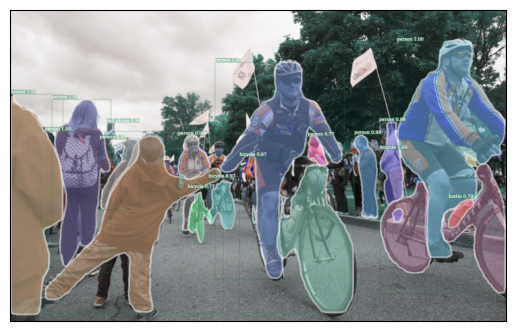

17790319373_bd19b24cfc_k_example_output.jpg


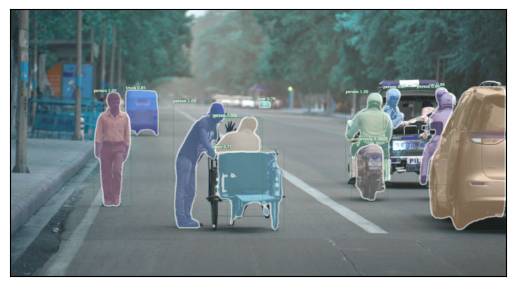

In [77]:
import cv2
import matplotlib.pyplot as plt
%matplotlib inline

op_dir = "/content/Detectron/demo/output"
for f in os.listdir(op_dir):
  if f.endswith('.jpg'):
    print(f)
    f_path = os.path.join(op_dir, f)
    img = cv2.imread(f_path)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(img)
    plt.show()